# Very naive deep learning on the vector of surrounding bases

---

### Data

Naive feature vectors. The original sequence of validation/test and train data does not overlap! ( but train data points can overlap with train data points, and test-validation can overlap with test-validation data ) This overlapping does not lead to unintentional label leakage!



### Notes


- better than acgt

---

Instruct theano to use gpu

In [1]:
import os
os.environ['THEANO_FLAGS']='device=gpu'

import sys
sys.path.append('../my_modules')
from loading_utils import read_my_data

import subprocess
import time

import numpy as np
import pandas as pd

import os,subprocess
workdir='/mnt/Data1/ribli/methylation_code/modelling'
subprocess.call(['mkdir',workdir])
os.chdir(workdir)

### Load data

In [2]:
train_id,train_x,train_y = read_my_data(
    fname='../prepare_data/big_train_feat_vect.csv')
test_id,test_x,test_y = read_my_data(
    fname='../prepare_data/big_test_feat_vect.csv')

Loading data... 
Loading data... 


### Load annotation

In [3]:
annot=pd.read_csv('../explore_data/relevant_annotations.csv',sep='\t',header=None)
annot.columns=['id','Regulatory_Feature_Group','Relation_to_UCSC_CpG_Island',
    'Strand','Infinium_Design_Type','Random_Loci','Methyl27_Loci']
annot.fillna(0,inplace=True)
train_merged=pd.DataFrame(train_id,columns=['id']).merge(annot,on=['id'])
test_merged=pd.DataFrame(test_id,columns=['id']).merge(annot,on=['id'])

### Select inidces for islands

In [4]:
cg_exl_idx=np.array([x[499]==2 and x[500]==3 for x in train_x])
annot_idx=np.array(np.zeros(len(train_x)),dtype=bool)
annot_idx[train_merged[train_merged.Relation_to_UCSC_CpG_Island=='Island'].index]=True
train_idx=cg_exl_idx & annot_idx
train_idx_0=cg_exl_idx & annot_idx & (train_y ==0)
train_idx_1=cg_exl_idx & annot_idx & (train_y ==1)


cg_exl_idx=np.array([x[499]==2 and x[500]==3 for x in test_x])
annot_idx=np.array(np.zeros(len(test_x)),dtype=bool)
annot_idx[test_merged[test_merged.Relation_to_UCSC_CpG_Island=='Island'].index]=True
test_idx=cg_exl_idx & annot_idx
test_idx_0=cg_exl_idx & annot_idx & (test_y==0)
test_idx_1=cg_exl_idx & annot_idx & (test_y==1)

### Reshape x data

In [5]:
#make it image like
train_x,test_x=[x.reshape((-1,1,1000,1)) for x in (train_x,test_x)]

### Train and test model

In [7]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
def fit_keras_model(model,train_x,train_y,test_x,test_y,validation_split=0.05):
    start=time.time()
    
    #callbacks
    best_model=ModelCheckpoint('best_model',save_best_only=True,verbose=1)
    early_stop=EarlyStopping(patience=7,verbose=1)
    
    #train it
    callb_hist=model.fit(train_x,train_y,nb_epoch = 100,
                         show_accuracy=True,verbose=1,
                        validation_split=validation_split,
                        callbacks=[best_model,early_stop])
    #predict
    model.load_weights('best_model')
    train_pred=model.predict_classes(train_x).ravel()
    test_pred=model.predict_classes(test_x).ravel()
    
    train_pred_pr=model.predict(train_x).ravel()
    test_pred_pr=model.predict(test_x).ravel()

    #check errors
    print 'train accuracy:',list((train_pred==train_y)).count(True)/float(len(train_y))
    print 'test accuracy:',list((test_pred==test_y)).count(True)/float(len(test_y))

    print 'It took:',time.time()-start    
    return train_pred,test_pred,train_pred_pr,test_pred_pr

### Balance labels

In [8]:
bal_train_x=np.concatenate([train_x[train_idx_0][:np.sum(train_idx_1)],train_x[train_idx_1]])
bal_train_y=np.concatenate([train_y[train_idx_0][:np.sum(train_idx_1)],train_y[train_idx_1]])

bal_test_x=np.concatenate([test_x[test_idx_0][:np.sum(test_idx_1)],test_x[test_idx_1]])
bal_test_y=np.concatenate([test_y[test_idx_0][:np.sum(test_idx_1)],test_y[test_idx_1]])


#shuffle them
#set seed to make the selection reproducible
rng=np.random.RandomState(42)
new_idx=rng.permutation(len(bal_train_y))
bal_train_x=bal_train_x[new_idx]
bal_train_y=bal_train_y[new_idx]

new_idx=rng.permutation(len(bal_test_y))
bal_test_x=bal_test_x[new_idx]
bal_test_y=bal_test_y[new_idx]

print np.mean(bal_train_y)
print np.mean(bal_test_y)

0.5
0.5


### Make acgt to atgc

In [9]:
bal_train_x[bal_train_x==4]=5
bal_train_x[bal_train_x==2]=4
bal_train_x[bal_train_x==5]=2

bal_test_x[bal_test_x==4]=5
bal_test_x[bal_test_x==2]=4
bal_test_x[bal_test_x==5]=2

### Build Convnet

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D,MaxPooling2D

input_dim=train_x.shape[2]
activation='relu'
loss='binary_crossentropy'
optimizer='adadelta'
init='uniform'
pool_size=(8,1)
window_size=5
dense_n=64

model = Sequential()

#Convolution layer 1
model.add(Convolution2D(20,window_size,1, border_mode='valid',input_shape=(1,input_dim,1)))
model.add(Activation(activation))
model.add(MaxPooling2D(pool_size=pool_size))
#model.add(Dropout(0.25))

#Convolution layer 2
model.add(Convolution2D(50,window_size,1, border_mode='valid'))
model.add(Activation(activation))
model.add(MaxPooling2D(pool_size=pool_size))
#model.add(Dropout(0.25))

#Dense layer
model.add(Flatten())
model.add(Dense(dense_n,activation=activation))
#model.add(Dropout(0.5))

#final layer
model.add(Dense(1, activation='sigmoid'))

#compile model
model.compile(loss=loss,optimizer=optimizer,class_mode='binary')

In [13]:
train_pred,test_pred,train_pred_pr,test_pred_pr=fit_keras_model(
    model,bal_train_x,bal_train_y,bal_test_x,bal_test_y,validation_split=0.2)

print '\nprediction balance:'
print np.mean(train_pred)
print np.mean(test_pred)

Train on 17651 samples, validate on 4413 samples
Epoch 1/100
17651/17651 [==============================] - 7s - loss: 0.7181 - acc: 0.5486 - val_loss: 0.6776 - val_acc: 0.5035
Epoch 00000: val_loss improved from inf to 0.67756, saving model to best_model
Epoch 2/100
17651/17651 [==============================] - 7s - loss: 0.6592 - acc: 0.6195 - val_loss: 0.6095 - val_acc: 0.6886
Epoch 00001: val_loss improved from 0.67756 to 0.60951, saving model to best_model
Epoch 3/100
17651/17651 [==============================] - 7s - loss: 0.6201 - acc: 0.6650 - val_loss: 0.9247 - val_acc: 0.5012
Epoch 00002: val_loss did not improve
Epoch 4/100
17651/17651 [==============================] - 7s - loss: 0.5623 - acc: 0.7163 - val_loss: 0.5158 - val_acc: 0.7467
Epoch 00003: val_loss improved from 0.60951 to 0.51580, saving model to best_model
Epoch 5/100
17651/17651 [==============================] - 7s - loss: 0.5293 - acc: 0.7333 - val_loss: 0.5241 - val_acc: 0.7292
Epoch 00004: val_loss did no

In [29]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline

from sklearn import metrics
def plot_roc(y,probs):
    fpr, tpr, thresholds = metrics.roc_curve(y,probs)
    auc=metrics.roc_auc_score(y,probs)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr,tpr,lw=2)
    plt.plot([0,1],[0,1],lw=2)
    plt.xlim(-0.01,1.01)
    plt.ylim(-0.01,1.01)
    plt.xlabel('FP rate')
    plt.ylabel('TP rate')
    print 'auc:',auc

auc: 0.900970493089


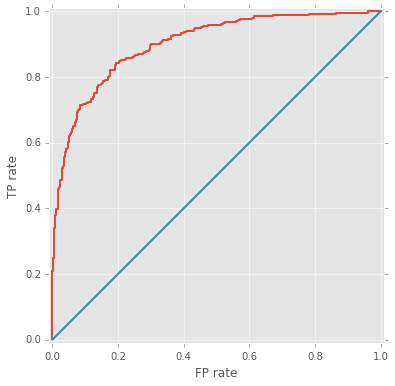

In [30]:
plot_roc(bal_test_y,test_pred_pr)